In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import copy

import pandas as pd

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
class SlotIntentDataset(Dataset):
    
    def __init__(self, datapath):
        self.data = []
        with open(datapath, 'r') as jsonl_file:
            for line in jsonl_file:
                self.data.append(json.loads(line))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if sample['history']:
            last_history = sample['history'][-1]
            last_history_str = f"{last_history['user_query']}? {last_history['response_text']}"
        else:
            last_history_str = " "
        gold_intent = ' <' + self.data[idx]['output'].split('(')[0].strip() + '>'
        return (self.data[idx]['input']+gold_intent, last_history_str, self.data[idx]['output'])

def dl_collate_fn(batch):
    return list(batch)

## Training

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '/kaggle/input/col772a3-data/A3'

In [4]:
train_ds = SlotIntentDataset(f'{data_path}/train.jsonl')
val_ds = SlotIntentDataset(f'{data_path}/dev.jsonl')

In [5]:
disfluent_words = ['uh', 'uhh', 'um', 'umm', 'uhm','uhmm', 'oh', 'ah', 'er', 'ummm', 'err']

def trim(s):
    s = s.lower()
    if s[-1] == ',':
        s = s[0:-1]
    return s

def remove_disfluency(ds):
    for i in range(len(ds.data)):
        if ds.data[i]['pattern'] != 'disfluency':
            continue
        words_list = ds.data[i]['input'].split(' ')
        last_word = ''
        s_last_word = ''
        for j in range(len(words_list)):
            if(len(words_list[j]) == 0):
                continue
            word = trim(words_list[j])
            if(word in disfluent_words):
                words_list[j] = ''
            elif (word == last_word):
                words_list[j] = ''
            elif (word == s_last_word):
                words_list[j] = ''
            else:
                s_last_word = last_word
                last_word = word
        words_list = list(filter(lambda x: x != '', words_list))        
        ds.data[i]['input'] = " ".join(words_list)
    return ds

def remove_disfluency_val(ds):
    for i in range(len(ds.data)):
        words_list = ds.data[i]['input'].split(' ')
        last_word = ''
        s_last_word = ''
        for j in range(len(words_list)):
            if(len(words_list[j]) == 0):
                continue
            word = trim(words_list[j])
            if(word in disfluent_words):
                words_list[j] = ''
            elif (word == last_word):
                words_list[j] = ''
            elif (word == s_last_word):
                words_list[j] = ''
            else:
                s_last_word = last_word
                last_word = word
        words_list = list(filter(lambda x: x != '', words_list))        
        ds.data[i]['input'] = " ".join(words_list)
    return ds

In [6]:
# train_ds = remove_disfluency(train_ds)
# val_ds = remove_disfluency_val(val_ds)

In [7]:
import random
random.seed(42)

In [8]:
DEBUG = False
if DEBUG:
    train_ds.data = random.sample(train_ds.data, 64)
    val_ds.data = random.sample(train_ds.data, 32)

In [9]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2, shuffle=False)

In [10]:
model = transformers.T5ForConditionalGeneration.from_pretrained("t5-base").to(device)
tokenizer = transformers.T5Tokenizer.from_pretrained("t5-base")
optimizer = optim.Adam(model.parameters(), lr=1e-5)

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [11]:
def process_batch(batch, tokenizer):
    encoder_strs = [f'[{b}] {a}: ' for a,b in zip(batch[0], batch[1])]
    decoder_strs = batch[2]
    
    enc = tokenizer(encoder_strs, text_target=decoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)
    return enc

In [12]:
def train(model, tokenizer, train_dl, val_dl, optimizer, scheduler=None, max_epochs=20, patience_lim=2):

    best_model = None
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    patience = 0

    for epoch in range(max_epochs):

        print(f'Epoch {epoch}:')
        train_loss = torch.tensor(0, dtype=torch.float, device=device)
        model.train()
        for batch in tqdm(train_dl):
            proc_batch = process_batch(batch, tokenizer)
            
            optimizer.zero_grad()
            loss = model(**proc_batch).loss
            loss.backward()
            optimizer.step()

            train_loss += loss.detach()
        
        if scheduler:
            scheduler.step()

        train_loss = train_loss.cpu()
        train_loss /= len(train_dl)
        print(f' Train Loss: {train_loss}')
        train_losses.append(train_loss)

        val_loss = torch.tensor(0, dtype=torch.float, device=device)
        true_labels = []
        pred_labels = []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dl):
                proc_batch = process_batch(batch, tokenizer)

                loss = model(**proc_batch).loss

                val_loss += loss.detach()
            
        val_loss = val_loss.cpu()
        val_loss /= len(val_dl)
        val_losses.append(val_loss)

        print(f' Val Loss: {val_loss}')
        print('')

        # early stopping
        if val_loss >= best_val_loss:
            if patience >= patience_lim:
                break
            else:
                patience += 1
        else:
            patience = 0
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_model = best_model.cpu()
            print(f'best model: {epoch}')
    
    return best_model, (train_losses, val_losses)

In [13]:
best_model, (train_losses, val_losses) = train(model, tokenizer, train_dl, val_dl, optimizer, max_epochs=20)
torch.save(best_model, 'intent-slot-t5.pt')

Epoch 0:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.7901300191879272


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.15479712188243866

best model: 0
Epoch 1:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.16034547984600067


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.08004835247993469

best model: 1
Epoch 2:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.0997748076915741


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.05183018743991852

best model: 2
Epoch 3:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.07080099731683731


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.039337705820798874

best model: 3
Epoch 4:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.05458103492856026


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.032620470970869064

best model: 4
Epoch 5:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.04419992119073868


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.02673179842531681

best model: 5
Epoch 6:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.03690348193049431


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.024575568735599518

best model: 6
Epoch 7:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.03140304237604141


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.02211335301399231

best model: 7
Epoch 8:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.027851473540067673


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.020599888637661934

best model: 8
Epoch 9:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.024711966514587402


  0%|          | 0/290 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7996b4f3bcb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 Val Loss: 0.019446374848484993

best model: 9
Epoch 10:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.02198815532028675


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.018429776653647423

best model: 10
Epoch 11:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.02014358527958393


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01791301742196083

best model: 11
Epoch 12:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.01839529350399971


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01797708123922348

Epoch 13:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.016814161092042923


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.017008142545819283

best model: 13
Epoch 14:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.01560006383806467


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.016775675117969513

best model: 14
Epoch 15:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.014539804309606552


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01737384870648384

Epoch 16:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.013206670992076397


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01670461893081665

best model: 16
Epoch 17:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.01255805604159832


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01659926027059555

best model: 17
Epoch 18:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.011865799315273762


  0%|          | 0/290 [00:00<?, ?it/s]

 Val Loss: 0.01706753857433796

Epoch 19:


  0%|          | 0/1938 [00:00<?, ?it/s]

 Train Loss: 0.011240728199481964


  0%|          | 0/290 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7996b4f3bcb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7996b4f3bcb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

 Val Loss: 0.016865340992808342



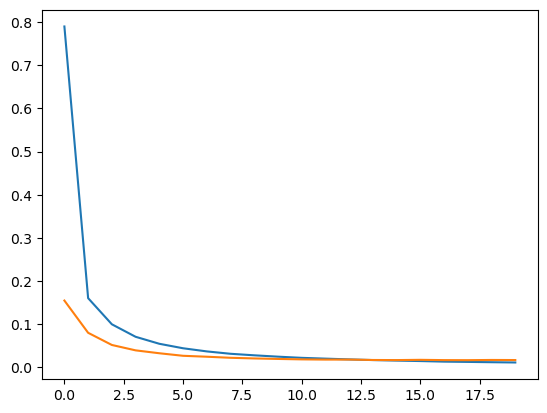

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

In [15]:
def generate(model, tokenizer, dl):

    pred_gens = []
    gens = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dl):
            encoder_strs, encoder_toks = process_batch_eval(batch, tokenizer)
            enc_len = encoder_toks['input_ids'].size(1)

            # beam search generations for syntax rather than nucleus sample
            gen = model.generate(
                **encoder_toks,
                num_beams=5,
                max_new_tokens=100,
            )
            
            gens += [{
                    'prompt': a,
                    'pred': b,
                    'gold': c
                } for a, b, c in zip(encoder_strs, tokenizer.batch_decode(gen, skip_special_tokens=True), batch[2])]
    
    return gens

In [16]:
def process_batch_eval(batch, tokenizer):
    
    labels = [toks.strip().split(' ')[0] for toks in batch[2]]
#     encoder_strs = [f'[{b}] {a} <{c}>: \xa0' for a,b,c in zip(batch[0], batch[1], labels)]
    encoder_strs = [f'[{b}] {a}: ' for a,b,c in zip(batch[0], batch[1], labels)]

    return encoder_strs, tokenizer(encoder_strs, return_tensors="pt", padding=True, truncation=True).to(device)

In [17]:
gens = generate(model, tokenizer, val_dl)

  0%|          | 0/290 [00:00<?, ?it/s]

In [18]:
def matches(y1, y2):
    return ("".join(y1.split()) == "".join(y2.split()))

def exact_match_metric(gens):
    cnt_correct = 0
    errors = []
    for gen in gens:
        if(matches(gen['gold'], gen['pred'])):
            cnt_correct += 1
        else:
            errors.append(gen)

    return cnt_correct/len(gens), errors

In [19]:
accuracy, errors = exact_match_metric(gens)

In [20]:
json.dump(gens, open('gens.json', 'w'), indent=4)
json.dump(errors, open('errors.json', 'w'), indent=4)

In [21]:
accuracy

0.8800690250215704